# Titanic data set example

In [1]:
from bhad.utils import (Discretize, mvt2mixture)
from bhad.model import BHAD
import numpy as np
import matplotlib.pyplot as plt
#from importlib import reload
from sklearn.datasets import fetch_openml

In [2]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True, parser="pandas")

X.head(2)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
X_cleaned = X.drop(['body', 'cabin', 'name', 'ticket', 'boat'], axis=1).dropna()
y_cleaned = y[X_cleaned.index]

X_cleaned.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 1281
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     684 non-null    float64 
 1   sex        684 non-null    category
 2   age        684 non-null    float64 
 3   sibsp      684 non-null    float64 
 4   parch      684 non-null    float64 
 5   fare       684 non-null    float64 
 6   embarked   684 non-null    category
 7   home.dest  684 non-null    object  
dtypes: category(2), float64(5), object(1)
memory usage: 39.0+ KB


Partition dataset:

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))


(458, 8)
(226, 8)
(array(['0', '1'], dtype=object), array([242, 216]))
(array(['0', '1'], dtype=object), array([122, 104]))


## Model explanation:

Retrieve local model explanations. Here: Specify all numeric and categorical columns explicitly

In [6]:
numeric_cols = list(X_train.select_dtypes(include=['float', 'int']).columns) 

cat_cols = list(X_train.select_dtypes(include=['object', 'category']).columns)

In [7]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('discrete', Discretize(nbins = None, verbose = False)),     
    ('model', BHAD(contamination = 0.01, numeric_features = numeric_cols, cat_features = cat_cols))
])

y_pred_train = pipe.fit_predict(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Fit BHAD on discretized data.
Input shape: (458, 8)
One-hot encoding categorical features.
Matrix dimension after one-hot encoding: (458, 319)
Finished training.
Score input data.


In [8]:
from bhad import explainer

#reload(explainer)

local_expl = explainer.Explainer(pipe.named_steps['model'], pipe.named_steps['discrete']).fit()

--- BHAD Model Explainer ---

Using fitted BHAD and discretizer.
Marginal distributions estimated using train set of shape (458, 8)


In [9]:
df_train = local_expl.get_explanation(nof_feat_expl = 5)

Create local explanations for 458 observations.


  0%|          | 0/458 [00:00<?, ?it/s]

In [10]:
global_feat_imp = local_expl.global_feat_imp         # based on X_train
global_feat_imp

,avg ranks
embarked,1.371179
sex,2.063319
parch,2.209607
sibsp,3.292576
age,3.604803
fare,3.967249
pclass,4.543668
home.dest,6.947598


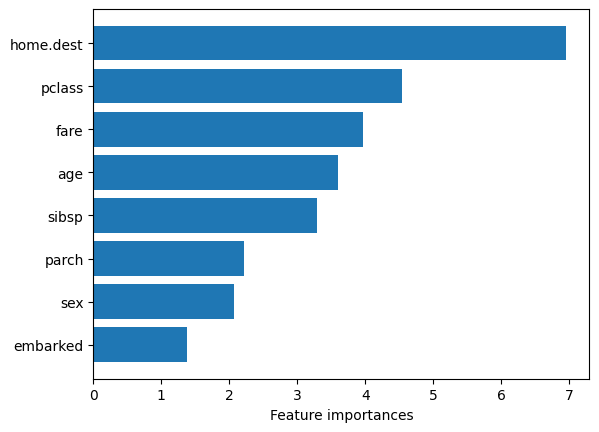

In [11]:
from matplotlib import pyplot as plt

plt.barh(global_feat_imp.index, global_feat_imp.values.flatten())
plt.xlabel("Feature importances");

In [13]:
for obs, ex in enumerate(df_train.explanation.values):
    if (obs % 100) == 0:
        print(f'\nObs. {obs}:\n', ex)


Obs. 0:
 parch (Cumul.perc.: 0.996): 5.0
home.dest (Perc.: 0.011): Sweden Winnipeg, MN
pclass (Cumul.perc.: 1.0): 3.0
sex (Perc.: 0.4): female

Obs. 100:
 home.dest (Perc.: 0.002): Tofta, Sweden Joliet, IL
pclass (Cumul.perc.: 1.0): 3.0

Obs. 200:
 home.dest (Perc.: 0.013): Brooklyn, NY

Obs. 300:
 home.dest (Perc.: 0.007): Bournmouth, England
age (Cumul.perc.: 0.05): 5.0
parch (Cumul.perc.: 0.969): 2.0
sex (Perc.: 0.4): female

Obs. 400:
 home.dest (Perc.: 0.002): Taalintehdas, Finland Hoboken, NJ
pclass (Cumul.perc.: 1.0): 3.0


In [14]:
y_pred_test = pipe.predict(X_test)


Score input data.
Apply fitted one-hot encoder.


In [15]:
df_test = local_expl.get_explanation(nof_feat_expl = 2)

Create local explanations for 226 observations.


  0%|          | 0/226 [00:00<?, ?it/s]

In [16]:
df_test.head(2)

,pclass,sex,age,sibsp,parch,fare,embarked,home.dest,explanation
0,2.0,male,36.0,1.0,2.0,27.7500,S,"Bournmouth, England","home.dest (Perc.: 0.007): Bournmouth, England\..."
1,1.0,male,49.0,1.0,1.0,110.8833,C,"Haverford, PA","home.dest (Perc.: 0.007): Haverford, PA\nfare ..."


In [17]:
for obs, ex in enumerate(df_test.explanation.values):
    #if (obs % 10) == 0:
        print(f'\nObs. {obs}:\n', ex)


Obs. 0:
 home.dest (Perc.: 0.007): Bournmouth, England
parch (Cumul.perc.: 0.969): 2.0

Obs. 1:
 home.dest (Perc.: 0.007): Haverford, PA
fare (Cumul.perc.: 0.919): 110.88

Obs. 2:
 home.dest (Perc.: 0.004): Minneapolis, MN
fare (Cumul.perc.: 0.878): 82.27

Obs. 3:
 home.dest (Perc.: 0.079): New York, NY
fare (Cumul.perc.: 0.854): 76.73

Obs. 4:
 sibsp (Cumul.perc.: 1.0): 5.0
home.dest (Perc.: 0.009): Wiltshire, England Niagara Falls, NY

Obs. 5:
 home.dest (Perc.: 0.009): Sweden Worcester, MA
sibsp (Cumul.perc.: 0.996): 4.0

Obs. 6:
 home.dest (Perc.: 0.002): Warwick, England

Obs. 7:
 home.dest (Perc.: 0.0): Huntington, WV

Obs. 8:
 home.dest (Perc.: 0.009): Paris, France
sex (Perc.: 0.4): female

Obs. 9:
 embarked (Perc.: 0.048): Q
home.dest (Perc.: 0.0): Co Cork, Ireland Charlestown, MA

Obs. 10:
 home.dest (Perc.: 0.0): Liverpool / Montreal, PQ

Obs. 11:
 embarked (Perc.: 0.048): Q
home.dest (Perc.: 0.0): Ireland Brooklyn, NY

Obs. 12:
 age (Cumul.perc.: 0.926): 57.0
home.dest (Pe

In [18]:
local_expl.global_feat_imp   # based on X_test

,avg ranks
home.dest,0.168142
pclass,2.460177
fare,2.858407
age,3.464602
sibsp,3.707965
sex,4.880531
parch,4.951327
embarked,5.508850
